#To begin with, we will download the data and import the necessary libraries

In [ ]:
#upload kaggle.json
from google.colab import files
files.upload()

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d bittlingmayer/amazonreviews

In [ ]:
!unzip /content/amazonreviews.zip

In [ ]:
!pip install pytorch_transformers
!pip install transformers

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io

%matplotlib inline

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 0

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [10]:
import bz2
from pprint import pprint

data_file = bz2.BZ2File("/content/train.ft.txt.bz2")
data = data_file.readlines()
data = [x.decode('utf-8') for x in data]

del data_file

for i in range(2):
    pprint(data[i])
    print('\n')

('__label__2 Stuning even for the non-gamer: This sound track was beautiful! '
 'It paints the senery in your mind so well I would recomend it even to people '
 'who hate vid. game music! I have played the game Chrono Cross but out of all '
 'of the games I have ever played it has the best music! It backs away from '
 'crude keyboarding and takes a fresher step with grate guitars and soulful '
 'orchestras. It would impress anyone who cares to listen! ^_^\n')


("__label__2 The best soundtrack ever to anything.: I'm reading a lot of "
 "reviews saying that this is the best 'game soundtrack' and I figured that "
 "I'd write a review to disagree a bit. This in my opinino is Yasunori "
 "Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening "
 'to it for years now and its beauty simply refuses to fade.The price tag on '
 'this is pretty staggering I must say, but if you are going to buy any cd for '
 'this much money, this is the only one that I feel would be worth 

In [11]:
train_sentences = [x.split(' ', 1)[1][:-1] for x in data][:70000]
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in data][:70000]

In [12]:
df = pd.DataFrame({'text': train_sentences, 'label': train_labels})
df.head()

,text,label
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


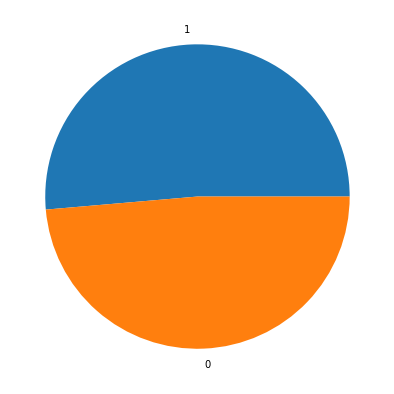

In [13]:
#leave only the necessary data
df = df[['text', 'label']]


#let's look at the distribution of classes
classes = df['label'].unique().tolist()
n_values = []

for cl in classes:
    n = df[df['label'] == cl].count().tolist()[1]
    n_values.append(n)

    
plt.figure(figsize=(7, 7))
plt.pie(n_values, labels = classes)
plt.show()

almost perfect

## Now let's pre-process the data.  The computer communicates in the language of numbers, so we need to translate text data into the format of tensors of numbers

In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", do_lower_case=False)

In [15]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 256
attention_masks = []

sentences = df.text.values
labels = df.label.values
  
  
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=MAX_LEN,
    dtype="long",
    truncating="post",
    padding="post"
    ) 

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

  
print("Before tokenization: ", sentences[2])
print("After: ", input_ids[2])
print('Attention mask: ', attention_masks[2])

Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


Before tokenization:  Amazing!: This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all the more if you've played the game) and the hope in "A Distant Promise" and "Girl who Stole the Star" have been an important inspiration to me personally throughout my teen years. The higher energy tracks like "Chrono Cross ~ Time's Scar~", "Time of the Dreamwatch", and "Chronomantique" (indefinably remeniscent of Chrono Trigger) are all absolutely superb as well.This soundtrack is amazing music, probably the best of this composer's work (I haven't heard the Xenogears soundtrack, so I can't say for sure), and even if you've never played the game, it would be worth twice the price to buy it.I wish I could give it 6 stars.
After:  [16035   106   131  1188  5945  1110  1139  5095  1390  1104  1155  1159
   117  1493  1205   119  1109  5827 12928  1104   107 11375  1468  1104
 17711   107   113  1134  2086  1155  1103  1167  1191  1128   

In [16]:
#now let's split data
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, random_state=0, test_size=0.1)
train_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=0, test_size=0.1)

In [17]:
train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)
train_labels = torch.tensor(train_labels)

val_inputs = torch.tensor(val_inputs)
val_masks = torch.tensor(val_masks)
val_labels = torch.tensor(val_labels)

batch_size = 8


train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

print('Train dataloader: ', len(train_dataloader))
print('Val dataloader: ', len(val_dataloader))

Train dataloader:  7875
Val dataloader:  875


# Model training

In [18]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
model.to(device)

100%|██████████| 435779157/435779157 [00:11<00:00, 38955228.37B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [19]:
# Parameters:
lr = 2e-5
adam_epsilon = 1e-8
epochs = 3

num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs


optimizer = AdamW(model.parameters(), eps=adam_epsilon, lr=lr, correct_bias=False)  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  

In [20]:
## Store our loss and accuracy for plotting
train_loss_set = []
learning_rate = []

# Gradients gets accumulated by default
model.zero_grad()


for e in tnrange(1, epochs + 1, desc='Epoch'):
    print("<" + "=" * 22 + ' ' + str(e) + " Epoch {_} " + "=" * 22 + ">")
    batch_loss = 0

    for step, batch in enumerate(train_dataloader):

      model.train()
      
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch

      # Forward pass
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      loss = outputs[0]
      
      # Backward pass
      loss.backward()
      
      # Clip the norm of the gradients to 1.0
      # Gradient clipping is not in AdamW anymore
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      
      # Update learning rate schedule
      scheduler.step()

      # Clear the previous accumulated gradients
      optimizer.zero_grad()
      
      # Update tracking variables
      batch_loss += loss.item()

    # Calculate the average loss over the training data.
    avg_train_loss = batch_loss / len(train_dataloader)

    #store the current learning rate
    for param_group in optimizer.param_groups:
      print("\n\tCurrent Learning rate: ", param_group['lr'])
      learning_rate.append(param_group['lr'])
      
    train_loss_set.append(avg_train_loss)
    print(F'\n\tAverage Training loss: {avg_train_loss}')
      
    # Validation

    model.eval()


    eval_accuracy, eval_mcc_accuracy, nb_eval_steps = 0, 0, 0

    for batch in val_dataloader:

      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch

      # Telling the model not to compute or store gradients, saving memory and speeding up validation
      with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      
      # Move logits and labels to CPU
      logits = logits[0].to('cpu').numpy()
      label_ids = b_labels.to('cpu').numpy()

      pred_flat = np.argmax(logits, axis=1).flatten()
      labels_flat = label_ids.flatten()
      
      df_metrics=pd.DataFrame({'Epoch': epochs, 'Actual_class': labels_flat, 'Predicted_class': pred_flat})
      
      tmp_eval_accuracy = accuracy_score(labels_flat, pred_flat)
      tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
      
      eval_accuracy += tmp_eval_accuracy
      eval_mcc_accuracy += tmp_eval_mcc_accuracy
      nb_eval_steps += 1

    print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
    print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if __name__ == '__main__':


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

<====================== 1 Epoch {_} ======================>


/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)



	Current Learning rate:  1.3333333333333333e-05

	Average Training loss: 0.27551597135209493

	Validation Accuracy: 0.9392857142857143

	Validation MCC Accuracy: 0.8716052700919882
<====================== 2 Epoch {_} ======================>

	Current Learning rate:  6.666666666666667e-06

	Average Training loss: 0.15570010305558782

	Validation Accuracy: 0.9414285714285714

	Validation MCC Accuracy: 0.8744015376681538
<====================== 3 Epoch {_} ======================>

	Current Learning rate:  0.0

	Average Training loss: 0.07547923531525376

	Validation Accuracy: 0.9422857142857143

	Validation MCC Accuracy: 0.8769915942835116


In [21]:
torch.save(model.state_dict(), 'weights_for_prediction.h5')
files.download('/content/weights_for_prediction.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Let's look at the results!

In [22]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [23]:
description = ['negative', 'positive']

#   *read with the expression*
text = 'Did you really think you could run away from home without my knowledge???!'

def get_prediction(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
    
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)

    idx = probs.argmax().item()

    return description[idx]

get_prediction(text)

'negative'